### Vegetation sensitivity

using consecutive counts idea for monthly aggregates and testing a few ideas Chris and Belle discussed


In [8]:
import os, sys
import xarray as xr
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', None)
dc = datacube.Datacube(app="veg_sensitivity")

from numba import jit

In [69]:
# # 13, -28 (Central west QLD, 2010 veg, 2015 bare)
# x = (1300000, 1350000)
# y = (-2750000, -2700000)

# # 13, -28 (Central west QLD, 2010 veg, 2015 bare) not square
# x = (1300000, 1325000)
# y = (-2750000, -2700000)

# # 1, -25 (Central NT, 2010 veg, 2015 bare)
# x = (150000, 200000)
# y = (-2450000, -2500000)

# # 16, -40 (Nowra, 2010 veg, 2015 veg)
# x = (1650000, 1700000)
# y = (-3900000, -3950000)

# # -4, -22 (West SA, 2010 bare, 2015 bare - only slight change in veg)
# x = (-400000, -350000)
# y = (-3100000, -3150000)

# 11, -48 (Southwest Tassie, 2010 veg 2015, bare 2015 - should be all veg/water, problem with obs count)
# x = (1150000, 1200000)
# y = (-4700000, -4750000)
# x = (1190000, 1190100)
# y = (-4700000, -4700100)

# -1, -28 (Uluru)
x = (-100000, -90000)
y = (-2737500, -2747500)

# # small area not square
# x = (1101550, 1101650)
# y = (-3970125, -3970175)

res = (-25, 25)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")

query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

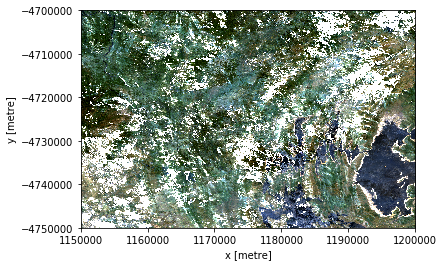

In [60]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

#### create the same virtual product as vegetat_veg_cat

In [70]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
# catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat_veg_testing.yaml')
catalog = catalog_from_file('./virtual_product_cat_veg_testing.yaml')

In [71]:
# load from datacube virtual product
# product = catalog['vegetat_veg_cat']
# can remove ls7 if not wanted
product = catalog['vegetat_veg_cat_ls7removed']
data = product.load(dc, **query)
data

<xarray.Dataset>
Dimensions:  (time: 22, x: 400, y: 400)
Coordinates:
  * y        (y) float64 -2.738e+06 -2.738e+06 ... -2.747e+06 -2.747e+06
  * x        (x) float64 -9.999e+04 -9.996e+04 ... -9.004e+04 -9.001e+04
  * time     (time) datetime64[ns] 2015-01-05T01:14:28 ... 2015-12-23T01:14:10
Data variables:
    BS       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... 54 54 57 55 52 51 52
    PV       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... 11 12 10 12 13 11 13
    NPV      (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... 34 32 31 32 33 36 33
    water    (time, y, x) int16 64 64 64 64 64 64 64 64 64 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

#### function to get consecutive counts for each pixel
- note `required_consecutive` will depend on time interval used to allign with FAO definition (i.e. fortnight = 4)

In [72]:
def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series
    
    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''
    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on",
            if np.all(np.isnan(tv_numpy[:,y,x])):
                consecutive_numpy[y,x] = np.nan
                continue            
            # num_consecutive set to 1 as if statement below requires looking at previous value
            # therefore cannot use required_consecutive=1, however not a problem
            # as we wouldn't want to know anything >=2 for required_consecutive
            num_consecutive = 1
            max_num_consecutive = 0
            # Go through all dates looking for consecutive values
            for z in range(1, tv_numpy.shape[0]):
                # If value is the same as previous date and same as consec_msk_val
                # iterate number of consecutive
                if (tv_numpy[z,y,x] == consec_msk_val): 
                    num_consecutive += 1
                    if num_consecutive > max_num_consecutive:
                        max_num_consecutive = num_consecutive
                # If not reset counter
                elif (not np.isnan(tv_numpy[z,y,x])):
                    num_consecutive = 1

            # If there enough consecutive 1's for required_consecutive
            # Set output to veg (1)
            if max_num_consecutive >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                 consecutive_numpy[y,x] = 0
    return consecutive_numpy

#### monthly aggregation


In [9]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
# tv.plot(col='month', col_wrap=4)

In [10]:
# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.uint8)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

# tv_summary.plot()

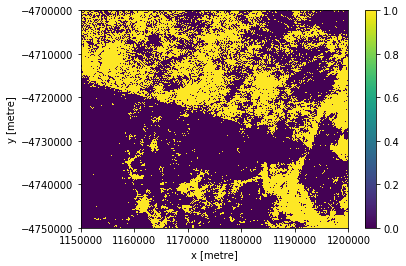

In [11]:
# not using consectutive for comparison #
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 4 fortnights
tv_summary_filt = (tv_summary >= 2).where(tv_summary.notnull())
tv_summary_filt.plot()

### IDEA 1: Integrating NPV to monthly - WIP

In [10]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0) & (data['NPV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')


# run pluging rules #
# Create mask where BS < PV
tv_mask_PV = data_month['BS'] < data_month['PV']

# Create mask where BS < NPV
tv_mask_NPV = data_month['BS'] < data_month['NPV']

####### works but very slow ######
# tv_mask = np.logical_or([tv_mask_PV], [tv_mask_NPV])
# tv_mask = xr.ufuncs.logical_or([tv_mask_PV], [tv_mask_NPV])

# tv_mask = np.any([[tv_mask_PV], [tv_mask_NPV]], axis=[0]) 


### IDEA 2: simple threshold on bare surface endmember - WIP
- where BS is dominant endmember i.e. veg = BS < 50
- every obs or monthly? time factor i.e. must satisfy < 66 for 2 months?
- changing `groupby` to max, median, min has a significant effect

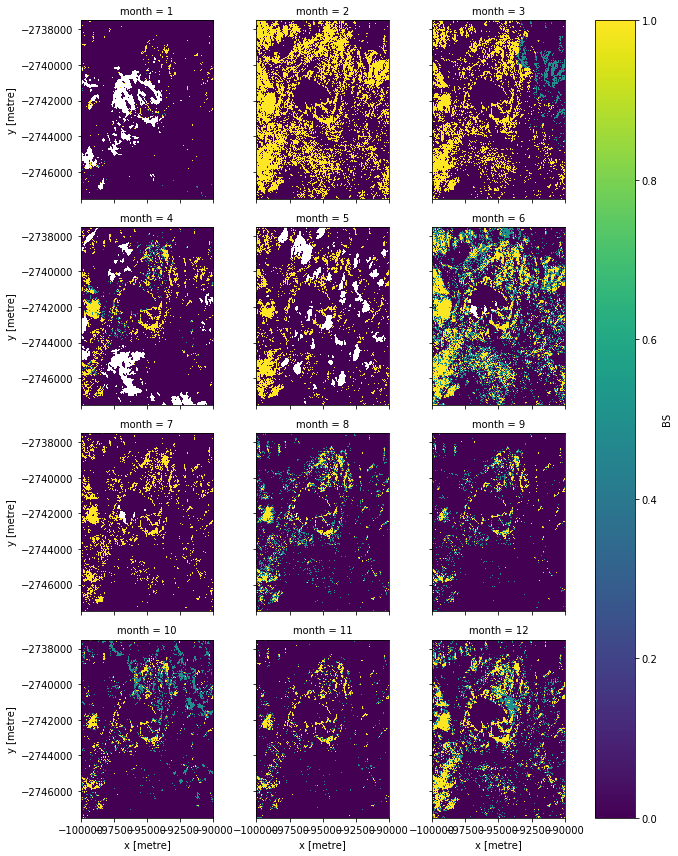

In [73]:
# Get areas with majority veg
tv_mask = data['BS'] < 50

# mask veg and BS (if either are nan, the < comparison defaults to False)
data_mask = tv_mask.where( (data['BS'] > 0))
data_mask = data_mask.where((data['water'] != 128), 0)
data_mask = data_mask.where((data['water'] != 132), 0)

# aggregate into monthly averages
data_month = data_mask.groupby('time.month').median(dim='time')
data_month.plot.imshow(col="month", col_wrap=3, vmin=0)

# # masking out no data areas before groupby so that no data is not considered for median function
# data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0) & (data['NPV'] > 0))
# data_month = data_mask.groupby('time.month').min(dim='time')
# # true == veg
# data_month_BS = data_month.BS < 50
# # print(data_month.BS)
# # data_month_BS

# # # Can't trust FC where there is water
# # # Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
# tv = data_month_BS.where((data_month['water'] != 128), 0)
# tv = data_month_BS.where((data_month['water'] != 132), 0)
# tv.plot(col='month', col_wrap=4)

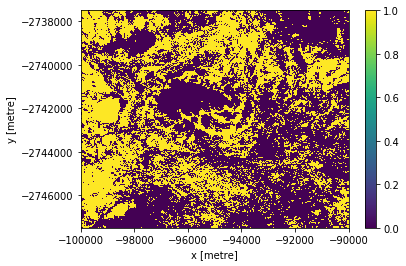

In [74]:
# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = data_month.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = data_month.median(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()